# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

**Point to note**
- The original dataset has no missing values

The two notes are:
G# (G sharp)
Ab (A flat)

In [233]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder,PowerTransformer
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

data = pd.read_csv('data/spotify_top_songs_audio_features.csv')
data.drop(columns=['track_name',"artist_names","id","source"],axis=0,inplace=True)
# sns.barplot(data.groupby(["source","id"]).sum())
# data.isna().sum()
# data.info()
#  !feature encoding

categorical_features = ["key","mode","time_signature"]
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[categorical_features])

encoded_feature_names = encoder.get_feature_names_out(categorical_features)
encoded_data_frame = pd.DataFrame(encoded_data, columns=encoded_feature_names)

def remove_correlating_features(features_df):
    corr = features_df.corr()
    correlating_feature_pair_list = corr[(corr > 0.40) & (corr < 1.0)].stack().index.tolist()
    print(correlating_feature_pair_list)
    for item in correlating_feature_pair_list:
        print(item[0], " ", item[1])
# combine features back together
data_pre_transformation = pd.concat([data.drop(columns=categorical_features), encoded_data_frame], axis=1)

remove_correlating_features(data_pre_transformation)

for item in data_pre_transformation.columns:
    if "#" in item:
        data_pre_transformation.rename(columns={item: item.split("#/")[0] + "_sharp"}, inplace=True)

# sns.heatmap(cleaned_data.corr())
# sns.histplot(cleaned_data.iloc[:,:cleaned_data.columns.size -22],bins=20)
# encoded_data_frame = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features))

[('energy', 'loudness'), ('loudness', 'energy'), ('weeks_on_chart', 'streams'), ('streams', 'weeks_on_chart')]
energy   loudness
loudness   energy
weeks_on_chart   streams
streams   weeks_on_chart


# Finding Optimum number of clusters

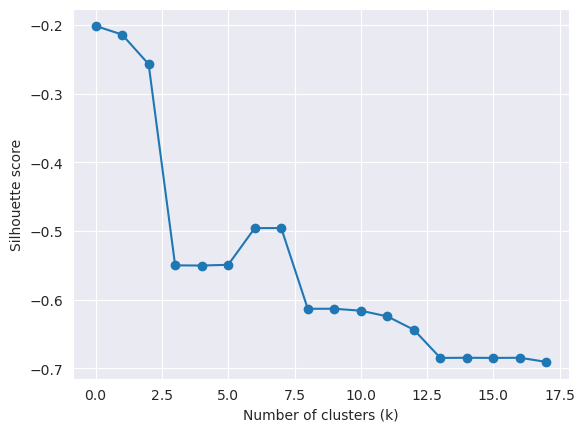

In [214]:


inertia = []
silhouettes = []
for i in list(range(1,20)):
    pipeline = Pipeline([
        ("scaler",RobustScaler()),("kmeans",KMeans(n_clusters=i,random_state=42))
    ])
    pipeline.fit(data_pre_transformation)
    inertia.append(pipeline.named_steps['kmeans'].inertia_)
    if i != 1:
        silhouettes.append(silhouette_score(data_pre_transformation, pipeline.named_steps['kmeans'].labels_))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.plot(silhouettes, marker='o')
# labels = pipeline.named_steps["kmeans"].labels_

# Clustering with optimum value

In [189]:
pipeline = Pipeline([
    ("scaler",RobustScaler()),("kmeans",KMeans(n_clusters=14,random_state=42))
])
pipeline.fit(data_pre_transformation)
print(silhouette_score(data_pre_transformation, pipeline.named_steps['kmeans'].labels_))

-0.15292552308240273
